<a href="https://colab.research.google.com/github/DavideScassola/xai-labs/blob/main/./SHAP/PyTorch Deep Explainer MNIST example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PyTorch Deep Explainer MNIST example

A simple example showing how to explain an MNIST CNN trained using PyTorch with Deep Explainer.
This notebook is from [the original SHAP repo](https://github.com/shap/shap/blob/master/notebooks/image_examples/image_classification/PyTorch%20Deep%20Explainer%20MNIST%20example.ipynb).

In [1]:
import numpy as np
import torch
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms

import shap

/home/davide/.local/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/davide/.local/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [6]:
batch_size = 128
num_epochs = 3
device = torch.device("cpu")


class Net(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 10, kernel_size=5),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(10, 20, kernel_size=5),
            nn.Dropout(),
            nn.MaxPool2d(2),
            nn.ReLU(),
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(320, 50),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(50, 10),
            nn.Softmax(dim=1),
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(-1, 320)
        x = self.fc_layers(x)
        return x


def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output.log(), target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print(
                f"Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)}"
                f" ({100.0 * batch_idx / len(train_loader):.0f}%)]"
                f"\tLoss: {loss.item():.6f}"
            )


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output.log(), target).item()  # sum up batch loss
            pred = output.max(1, keepdim=True)[
                1
            ]  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print(
        f"\nTest set: Average loss: {test_loss:.4f},"
        f" Accuracy: {correct}/{len(test_loader.dataset)}"
        f" ({100.0 * correct / len(test_loader.dataset):.0f}%)\n"
    )


train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(
        "mnist_data",
        train=True,
        download=True,
        transform=transforms.Compose([transforms.ToTensor()]),
    ),
    batch_size=batch_size,
    shuffle=True,
)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST(
        "mnist_data", train=False, transform=transforms.Compose([transforms.ToTensor()])
    ),
    batch_size=batch_size,
    shuffle=True,
)

model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

for epoch in range(1, num_epochs + 1):
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.315778
Train Epoch: 1 [12800/60000 (21%)]	Loss: 2.176827
Train Epoch: 1 [25600/60000 (43%)]	Loss: 1.228509
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.994253
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.758053

Test set: Average loss: 0.0048, Accuracy: 8915/10000 (89%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.806572
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.577098
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.738026
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.614723
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.437345

Test set: Average loss: 0.0028, Accuracy: 9333/10000 (93%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.410334
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.298142
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.373933
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.319923
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.401648

Test set: Average loss: 0.0019, Accuracy: 9504/10000 (95%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.372520
Train Epoch: 4 [12800/60000 (21%)]	Lo

In [7]:
# since shuffle=True, this is a random sample of test data
batch = next(iter(test_loader))
images, _ = batch

background = images[:100]
test_images = images[100:103]

e = shap.DeepExplainer(model, background)
shap_values = e.shap_values(test_images)

In [8]:
shap_numpy = list(np.transpose(shap_values, (4, 0, 2, 3, 1)))
test_numpy = np.swapaxes(np.swapaxes(test_images.numpy(), 1, -1), 1, 2)

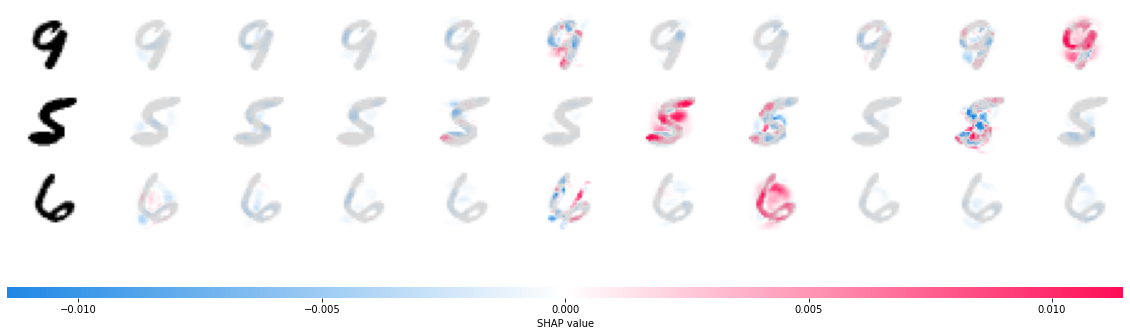

In [9]:
# plot the feature attributions
shap.image_plot(shap_numpy, -test_numpy)

The plot above shows the explanations for each class on four predictions. Note that the explanations are ordered for the classes 0-9 going left to right along the rows.